# Facial Keypoint Detection
<p style="text-align:justify"> In this exercise we will build a
CNN for facial key point detection. 
    
Given a set of faces marked with $(x, y)$ coordinates of facial keypoints, say, left_eye left corner, left_eye right corner, right_eye left corner, right_eye right corner etc - can we build and train a model that if given a seen or unseen face will automatically detect the coordinates of the facial keypoints. See Figure 1 for an example of images with keypoints marked. 

<img src="images/facial_keypoints.png" style="width:350px;height:150px;">
<caption><center> <u> <font color='purple'> Figure 1 </u><font color='purple'>  : Faces with keypoints </center></caption>
<br>

Keypoints across all faces for training are to be ordered consistently. 

The training data and test data are available as csv files. The images in the training set are gray-scale and are of size 96x96. Each image is associated with ground_truth (x, y) coordinates of 15 keypoints (totalling to 30 values) as shown in Figure 1. The model we are going to build is as follows:

i/p-->conv layer-->ReLU-->maxpool-->conv layer-->ReLU-->maxpool-->conv layer-->ReLU-->maxpool-->linear-->ReLU
-->linear-->ReLU-->Linear

The details are as follows:
<span style="color:brown">
<br>
i/p: 1 x 96 x 96
<br>
conv1: in_channels = 1, num_of_filters also called outchannels = 32, kernel_size = (3, 3), stride = (1, 1), no            padding
<br>
pool1: max pooling, kernel_size = (2, 2), no padding
<br>
conv2: in_channels = 32, outchannels = 64, kernel_size = (2, 2), stride = (1, 1), no padding
<br>
pool2: max pooling, kernel_size = (2, 2), no padding
<br>
conv3: in_channels = 64, outchannels = 128, kernel_size = (2, 2), stride = (1, 1), no padding
<br>
pool3: max pooling, kernel_size = (2, 2), no padding
<br>
fc1: in_features = 128, out_features = 500
<br>
fc2: in_features = 500, out_features = 500
<br>
fc3: in_features = 500, out_features = 30
</span>
<br>
<br>
**Dimensions through the model:**
<br>
<br>
1x96x96 $\xrightarrow[\text{relu}]{\text{conv +}}$ 32x94x94 $\xrightarrow[\text{}]{\text{pool}}$ 32x47x47 $\xrightarrow[\text{relu}]{\text{conv +}}$ 64x46x46 $\xrightarrow[\text{}]{\text{pool}}$ 64x23x23$\xrightarrow[\text{relu}]{\text{conv +}}$ 128x22x22 $\xrightarrow[\text{}]{\text{pool}}$ 128x11x11 = 15488$\xrightarrow[\text{relu}]{\text{fc +}}$ 500 $\xrightarrow[\text{relu}]{\text{fc +}}$ 500$\xrightarrow[\text{}]{\text{fc}}$ 30

- You should create a class for building the above model.
- You should create a Dataset class for supplying training, valid and test data to the DataLoader. Since the data is in form of csv files, you should use a csv file reader in the Dataset class to read the csv files. Look and analyse the data to get familiar with it. The train/valid split could be 70-30 or 80-20 rule. The data augumentation to be used for train data and only train data is RandomHorizontalFlip. Note that when the image is flipped, the corresponding keypoints order also will change.
- Use MSE loss as loss criterion. Use SGD with momentum= 0.9  as optimizer.
- You should have a function that plots the train loss and valid loss against number of epochs.
- You should have a function to test the model.
- You should have a function that prints a batch of images with keypoints superimposed on them.
- You should have a function that prints the total number of learnable parameters of the model.
- Your submission deadline is Sep 5th, 2019.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import pandas as pd
import matplotlib.pyplot as plt

In [0]:

# class for building the above model
class Model_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, stride=(1,1))
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(32, 64, 2, stride=(1,1))
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.conv3 = nn.Conv2d(64, 128, 2, stride=(1,1))
    self.pool3 = nn.MaxPool2d(kernel_size=2)
    self.fc1 = nn.Linear(128*11*11, 500)
    self.fc2 = nn.Linear(500, 500)
    self.fc3 = nn.Linear(500, 30)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)
    x = x.view(-1, 128*11*11)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ls /content/drive/My\ Drive/Colab\ Notebooks/Assgn4/data

test.csv  train_drop_missed.csv  training.csv


In [0]:
#data_path = '/content/drive/My Drive/Colab Notebooks/Assgn4/data/training.csv'
#data = pd.read_csv(data_path).dropna()
#data.to_csv('/content/drive/My Drive/Colab Notebooks/Assgn4/data/train_drop_missed.csv',index=False)

In [0]:
from torch.utils.data import Dataset
import numpy as np

IMG_SIZE = 96


# Dataset class for supplying training, valid and test data to the DataLoader
class FacialKeyPoint():
  def __init__(self, data_path='/content/drive/My Drive/Colab Notebooks/Assgn4/data/train_drop_missed.csv', train=True, transform=None):
    self.transform = transform
    self.data = pd.read_csv(data_path)       # reads the csv
    self.train = train
    self.key = 'Image'


  def __len__(self):                # returns the size of the dataset
    return len(self.data)
  

  def __getitem__(self, i):
    assert 0<=i<len(self.data), f'i={i} corresponding to item number {i+1} exceeds size of the dataset that is {self.__len__()}'
    image = np.fromstring(self.data[self.key][i], dtype=np.float32, sep=' ').reshape(1,IMG_SIZE,IMG_SIZE)
    if self.train:
      keypoints = np.array([self.data[self.data.keys()[j]][i] for j in range(0, len(self.data.keys())-1)], dtype=np.float32)
      if self.transform:
        new_img = self.transform(torch.from_numpy(image)).numpy()
        if not np.array_equal(image, new_img):
          keypoints = keypoints[[2,3,0,1,8,9,10,11,4,5,6,7,16,17,18,19,12,13,14,15,20,21,24,25,22,23,26,27,28,29]]
          for j in range(0,30,2):
            keypoints[j] = IMG_SIZE-1-keypoints[j]
          image = new_img
          #print("\nEntered")
          
    else:
      image = image/255.
      image = torch.from_numpy(image)
      image = image.to(dtype=torch.float32)
      return image
    
    image = image/255.
    image = torch.from_numpy(image)
    image = image.to(dtype=torch.float32)
    keypoints = keypoints/95.
    keypoints = torch.tensor(keypoints, dtype=torch.float32)
    return image, keypoints

In [0]:
#data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assgn4/data/train_drop_missed.csv')
#data.T

In [8]:
# Instantiate the Dataset class and extract some images and their keypoints.
dset = FacialKeyPoint()

image, keypoints = dset[5]
print(f'Image {5} with size {image.size()} and keypoints {keypoints}')

image, keypoints = dset[11]
print(f'Image {11} with size {image.size()} and keypoints {keypoints}')

image, keypoints = dset[203]
print(f'Image {208} with size {image.size()} and keypoints {keypoints}')

image, keypoints = dset[208]
print(f'Image {208} with size {image.size()} and keypoints {keypoints}')


Image 5 with size torch.Size([1, 96, 96]) and keypoints tensor([0.7335, 0.4207, 0.3072, 0.3954, 0.6617, 0.4228, 0.8095, 0.4334, 0.3832,
        0.4144, 0.2291, 0.4060, 0.6291, 0.3332, 0.8770, 0.3722, 0.4148, 0.3215,
        0.1574, 0.3384, 0.5523, 0.6189, 0.6828, 0.8681, 0.3367, 0.8597, 0.5190,
        0.8262, 0.5203, 0.9884])
Image 11 with size torch.Size([1, 96, 96]) and keypoints tensor([0.7025, 0.4199, 0.3186, 0.4086, 0.6423, 0.4199, 0.7702, 0.4349, 0.3826,
        0.4199, 0.2622, 0.4161, 0.5858, 0.3145, 0.8530, 0.3747, 0.4654, 0.3070,
        0.1643, 0.3596, 0.5106, 0.5967, 0.6498, 0.8677, 0.3525, 0.8564, 0.5106,
        0.7661, 0.5030, 0.9957])
Image 208 with size torch.Size([1, 96, 96]) and keypoints tensor([0.7354, 0.3555, 0.2905, 0.3825, 0.6579, 0.3724, 0.8230, 0.3825, 0.3647,
        0.3993, 0.2130, 0.4095, 0.5905, 0.2039, 0.8635, 0.2544, 0.4118, 0.2140,
        0.1254, 0.3218, 0.4759, 0.5342, 0.6983, 0.8274, 0.3310, 0.8510, 0.4894,
        0.7397, 0.5028, 0.9217])
Image 208 

In [0]:
model = Model_CNN()

In [10]:
# Initializing the parameters
def init_params(m):
  if type(m) == nn.Linear:
    m.weight.data = torch.randn(m.weight.size())*.01
    m.bias.data = torch.zeros(m.bias.size())
  if type(m) == nn.Conv2d:
    m.weight.data = torch.randn(m.weight.size())*.01
    m.bias.data = torch.zeros(m.bias.size())

model.apply(init_params) # applies init_params function to each immediate child Module and itself


Model_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15488, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=30, bias=True)
)

In [0]:
# Training our model
train_loss = []
valid_loss = []
def train(model, train_loader, valid_loader, loss_criterion, optimizer, num_epochs):
  for epoch in range(num_epochs):                 # for each epoch
    for images, keypoints in train_loader:        # for each batch of images and keypoints
      if torch.cuda.is_available():               # if gpu available,
        images = images.to(device = 'cuda') 
        keypoints = keypoints.to(device = 'cuda') # move batch of images and keypoints to gpu memory 
      outputs = model(images)                     # do forward propagation
      #print(outputs[0])
      loss = loss_criterion(outputs, keypoints)   # compute loss
      optimizer.zero_grad()                       # make sure gradients of parameters are zeroed before backpropagation to avoid accumulation
      loss.backward()                             # do the backpropagation
      optimizer.step()                            # update the parameters
    if epoch%10 == 0:
      print(f'Training loss at epoch {epoch+1}:\t{loss.item()}')
    if epoch == 99:
      print(f'Training loss at epoch {epoch+1}:\t{loss.item()}')
    train_loss.append(loss.item())
    
    for images, keypoints in valid_loader:        # for each batch of images and keypoints
      if torch.cuda.is_available():               # if gpu available,
        images = images.to(device = 'cuda') 
        keypoints = keypoints.to(device = 'cuda') # move batch of images and keypoints to gpu memory 
      outputs = model(images)                     # do forward propagation
      loss = loss_criterion(outputs, keypoints)   # compute loss
      optimizer.zero_grad()                       # make sure gradients of parameters are zeroed before backpropagation to avoid accumulation
      loss.backward()                             # do the backpropagation
      optimizer.step()                            # update the parameters
      outputs = model(images) # do forward propagation
      #print(outputs[0])
      #print(keypoints[0])
      diff = abs(outputs*95-keypoints)
      t = diff<(5./95.)
      t = t.type(torch.float)
      accuracy = t.sum()/t.view(-1).shape[0]
    if epoch%10 == 0:
      print(f'Validation loss at epoch {epoch+1}:\t{loss.item()}')
    if epoch == 99:
      print(f'Validation loss at epoch {epoch+1}:\t{loss.item()}')
    valid_loss.append(loss.item())

  print(f'Validation ACCURACY: {accuracy}')

In [0]:
# Testing our model
def test(model, loader, loss_criterion):
  total = 0
  correct = 0
  for data in loader: # for each batch of images and labels
    images = data
    if torch.cuda.is_available(): # if gpu available,
      images = images.to(device = 'cuda') 
    outputs = model(images) # do forward propagation
    return outputs

In [13]:
def main(model):
  if torch.cuda.is_available():
    model = model.to(device = 'cuda') # move entire model to gpu memory; all its parameters, buffers are moved to gpu memory
  loss_criterion = nn.MSELoss() # instantiate the loss criterion; since we are doing binary classification, 
                                # we will use binary cross entropy loss
  optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)        # instantiate optimizer; here we are using stochastic gradient descent
                                                               # with learning rate as 0.008 and momentum as 0.9
  
  # next few lines will build the loader to load the data
  ########################################################################
  transforms = torchvision.transforms.Compose([
                                torchvision.transforms.ToPILImage(),
                                torchvision.transforms.RandomHorizontalFlip(),
                                torchvision.transforms.ToTensor()
                                              ])
  
  dataset = FacialKeyPoint(transform=transforms)
  valid_split = 0.2
  size = len(dataset)
  indices = list(range(size))
  np.random.shuffle(indices)
  split = int(np.floor(valid_split*size))
  train_idx, valid_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=64, sampler=train_sampler)
  valid_loader = torch.utils.data.DataLoader(dataset, batch_size=64, num_workers=64, sampler=valid_sampler)
  
  data = FacialKeyPoint(data_path='/content/drive/My Drive/Colab Notebooks/Assgn4/data/test.csv', train=False)
  test_loader = torch.utils.data.DataLoader(data, batch_size=64, num_workers=64)

  train(model, train_loader, valid_loader, loss_criterion, optimizer, 100)
  output = test(model, test_loader, loss_criterion)
  
  return data, output


if __name__ == '__main__':
   data, output = main(model)

Training loss at epoch 1:	0.2547794282436371
Validation loss at epoch 1:	0.24679876863956451
Training loss at epoch 11:	0.015901820734143257
Validation loss at epoch 11:	0.014333848841488361
Training loss at epoch 21:	0.0011461909161880612
Validation loss at epoch 21:	0.0013327483320608735
Training loss at epoch 31:	0.0008745940285734832
Validation loss at epoch 31:	0.0010760524310171604
Training loss at epoch 41:	0.001167731243185699
Validation loss at epoch 41:	0.0010406244546175003
Training loss at epoch 51:	0.00116273807361722
Validation loss at epoch 51:	0.0011771053541451693
Training loss at epoch 61:	0.0011110528139397502
Validation loss at epoch 61:	0.0010375053388997912
Training loss at epoch 71:	0.0010260026901960373
Validation loss at epoch 71:	0.0012378029059618711
Training loss at epoch 81:	0.0008438630029559135
Validation loss at epoch 81:	0.0011733308201655746
Training loss at epoch 91:	0.0009241898078471422
Validation loss at epoch 91:	0.0011092323111370206
Training los

In [0]:
extra_output = output

In [0]:
#output = extra_output

In [0]:
# Function that prints a batch of images with keypoints superimposed on them.
def show_images(data, keypts, batch, train=True):
  for i, idx in enumerate(batch):
    if train:
      image, keypoints = data[idx]
    else:
      image = data[idx]
      keypoints = keypts[idx]
    image = image.view(-1).view(96,96)
    keypoints = keypoints.reshape(-1,2)*95.
    
    plt.figure(figsize=(15,10))
    plt.subplot(len(batch)/5+1, 5, i+1)
    plt.axis('off')

    plt.imshow(image)
    if len(keypoints):
      plt.scatter(keypoints[:,0], keypoints[:,1], marker ='.', c='r')
      
  plt.show()

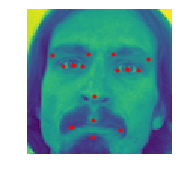

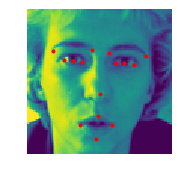

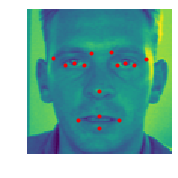

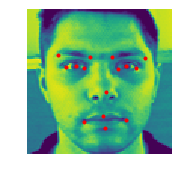

In [17]:
show_images(dset, None, range(4), True)

In [0]:
output = output.to('cpu').detach().numpy()

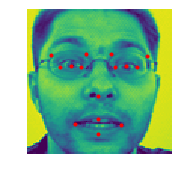

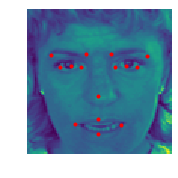

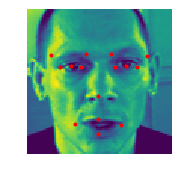

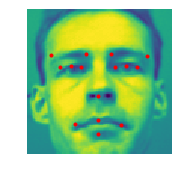

In [21]:
show_images(data, output, range(4), False)

In [0]:
# Function that prints the total number of learnable parameters of the model.
def num_params(model):
  return sum([p.numel() for p in model.parameters() if p.requires_grad is True]) 

In [27]:
num = num_params(model)
print(f'Total number of learnable parameters of the model: {num}')

Total number of learnable parameters of the model: 8051502


In [0]:
# Function that plots the train loss and valid loss against number of epochs.
def plot_losses(train_loss, valid_loss):
  x = range(len(train_loss))
  plt.plot(x, train_loss, c='b')
  plt.plot(x, valid_loss, c='r')
  plt.show()

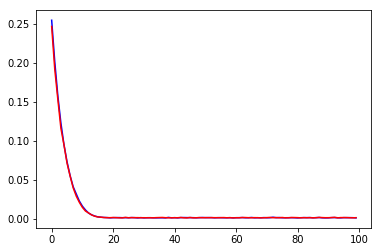

In [25]:
plot_losses(train_loss, valid_loss)